In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [0]:
del sorted_data

In [0]:
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46072/46072 [00:17<00:00, 2693.26it/s]


In [14]:
preprocessed_reviews[1500]

'The orange and lemon peels make this tea very hippy Despite the initial oohing and ahing over the pretty blue flowers this is a regrettable purchase I was hoping for a stronger bergamot component than Twinings Earl Grey but instead I got something that seems very herbal Blech I disagree with the positive reviews'

In [0]:
X = np.array(preprocessed_reviews)
y = np.array(final['Score'])

In [0]:
X_train = X[:30000]
X_test = X[30000:]
y_train = y[:30000]
y_test = y[30000:]

In [0]:
del X,y

In [18]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


In [0]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)

In [0]:
X_test = tokenizer.texts_to_sequences(X_test)

In [21]:
print(X_train[0])

[9, 21, 4, 66, 28, 592, 3, 1, 2729, 47, 5, 1508, 2, 80, 1, 23, 13, 1372, 4579, 3, 2730, 4355, 319, 2, 117, 1, 2, 115, 120, 2489, 64]


In [22]:
print(X_test[0])

[2, 14, 9, 46, 272, 41, 1, 75, 22, 4, 179, 6, 5, 355, 3, 122, 3, 5, 34, 51, 16, 17, 295, 4, 1062, 11, 172, 122, 297, 332, 384, 2, 761, 1970, 6, 12, 103, 212, 287, 271, 3, 2364, 295, 6, 25, 2, 1463, 57, 67, 3, 21, 230, 7, 86, 6, 192, 2, 21, 1453, 63, 767, 4, 268, 19, 2, 39, 111, 33, 1124, 3, 2, 111, 46, 30, 262, 41, 265, 218, 25, 6, 36, 219, 29, 114]


In [23]:
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[0])

(30000, 500)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [23]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Instructions for updating:
Use tf.cast instead.
Train on 30000 samples, validate on 16072 samples
Epoch 1/10
30000/30000 [==============================] - 518s 17ms/step - loss: 0.3057 - acc: 0.8810 - val_loss: 0.2498 - val_acc: 0.9074
Epoch 2/10
30000/30000 [==============================] - 517s 17ms/step - loss: 0.1946 - acc: 0.9267 - val_loss: 0.2256 - val_acc: 0.9102
Epoch 3/10
30000/30000 [==============================] - 516s 17ms/step - loss: 0.1659 - acc: 0.9396 - val_loss: 0.2614 - val_acc: 0.9013
Epoch 4/10
30000/30000 [==============================] - 519s 17ms/step - loss: 0.1465 - acc: 0.9468 - val_loss: 0.2495 - val_acc: 0.9024
Epoch 5/10
30000/30000 [==============================] - 520s 17ms/step - loss: 0.1327 - acc: 0.9506 - val_loss: 0.2447 - val_acc: 0.9111
Epoch 6/10
30000/30000 [==============================] - 519s 17ms/step - loss: 0.1089 - acc: 0.9615 - val_loss: 0.2761 - val_acc: 0.9113
Epoch 7/10
30000/30000 [==============================] - 522s 17ms/

In [25]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.4047449541349111
Test accuracy: 0.9039323046291687


In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

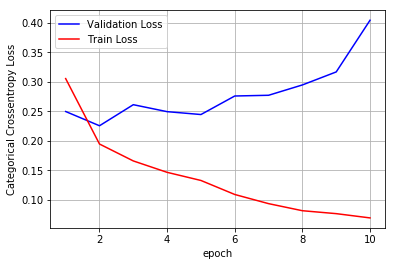

In [27]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [28]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 30000 samples, validate on 16072 samples
Epoch 1/10
30000/30000 [==============================] - 521s 17ms/step - loss: 0.3264 - acc: 0.8676 - val_loss: 0.2755 - val_acc: 0.8759
Epoch 2/10
30000/30000 [==============================] - 520s 17ms/step - loss: 0.2031 - acc: 0.9194 - val_loss: 0.2190 - val_acc: 0.9102
Epoch 3/10
30000/30000 [==============================] - 521s 17ms/step - loss: 0.1677 - acc: 0.9347 - val_loss: 0.2302 - val_acc: 0.9158
Epoch 4/10
30000/30000 [==============================] - 522s 17ms/step - loss: 0.1473 - acc: 0.9451 - val_loss: 0.2266 - val_acc: 0.9135
Epoch 5/10
30000/30000 [==============================] - 523s 17ms/step - loss: 0.1305 - acc: 0.9517 - val_loss: 0.2374 - val_acc: 0.9121
Epoch 6/10
30000/30000 [==============================] - 519s 17ms/step - loss: 0.1206 - acc: 0.9541 - val_loss: 0.2433 - val_acc: 0.9065
Epoch 7/10
30000/30000 [==============================] - 520s 17ms/step - loss: 0.1106 - acc: 0.9596 - val_loss: 0.

In [30]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.28784663052167864
Test accuracy: 0.9005724240915879


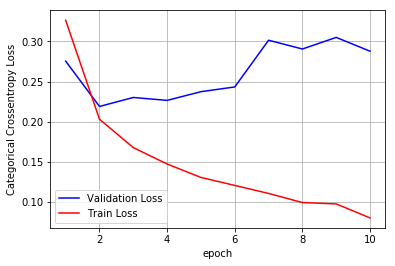

In [31]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [32]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(8, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 808       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 214,017
Trainable params: 214,017
Non-trainable params: 0
_________________________________________________________________
None

In [33]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 30000 samples, validate on 16072 samples
Epoch 1/10
30000/30000 [==============================] - 525s 18ms/step - loss: 0.3565 - acc: 0.8517 - val_loss: 0.3018 - val_acc: 0.8774
Epoch 2/10
30000/30000 [==============================] - 525s 18ms/step - loss: 0.4134 - acc: 0.8610 - val_loss: 0.4814 - val_acc: 0.8157
Epoch 3/10
30000/30000 [==============================] - 523s 17ms/step - loss: 0.4464 - acc: 0.8451 - val_loss: 0.4810 - val_acc: 0.8158
Epoch 4/10
30000/30000 [==============================] - 522s 17ms/step - loss: 0.4438 - acc: 0.8454 - val_loss: 0.4785 - val_acc: 0.8158
Epoch 5/10
30000/30000 [==============================] - 521s 17ms/step - loss: 0.4409 - acc: 0.8455 - val_loss: 0.4785 - val_acc: 0.8158
Epoch 6/10
30000/30000 [==============================] - 522s 17ms/step - loss: 0.4388 - acc: 0.8455 - val_loss: 0.4797 - val_acc: 0.8158
Epoch 7/10
30000/30000 [==============================] - 520s 17ms/step - loss: 0.4370 - acc: 0.8455 - val_loss: 0.

In [34]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.4797712722009779
Test accuracy: 0.8158909905425585


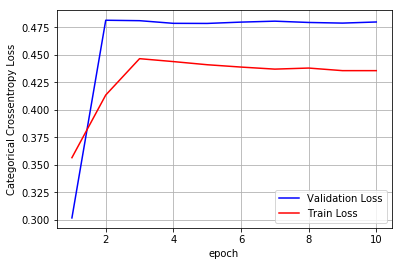

In [35]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [36]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(8, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 808       
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 214,017
Trainable params: 214,017
Non-trainable params: 0
_________________________________________________________________
None

In [37]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 30000 samples, validate on 16072 samples
Epoch 1/10
30000/30000 [==============================] - 524s 17ms/step - loss: 0.5235 - acc: 0.8192 - val_loss: 0.4812 - val_acc: 0.8159
Epoch 2/10
30000/30000 [==============================] - 522s 17ms/step - loss: 0.4748 - acc: 0.8456 - val_loss: 0.4727 - val_acc: 0.8159
Epoch 3/10
30000/30000 [==============================] - 521s 17ms/step - loss: 0.4339 - acc: 0.8455 - val_loss: 0.3949 - val_acc: 0.8159
Epoch 4/10
30000/30000 [==============================] - 522s 17ms/step - loss: 0.3526 - acc: 0.8664 - val_loss: 0.3210 - val_acc: 0.8675
Epoch 5/10
30000/30000 [==============================] - 522s 17ms/step - loss: 0.2989 - acc: 0.8893 - val_loss: 0.2906 - val_acc: 0.8828
Epoch 6/10
30000/30000 [==============================] - 523s 17ms/step - loss: 0.2707 - acc: 0.9024 - val_loss: 0.2993 - val_acc: 0.8783
Epoch 7/10
30000/30000 [==============================] - 525s 17ms/step - loss: 0.2521 - acc: 0.9105 - val_loss: 0.

In [38]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.26015176462735506
Test accuracy: 0.9011324041811847


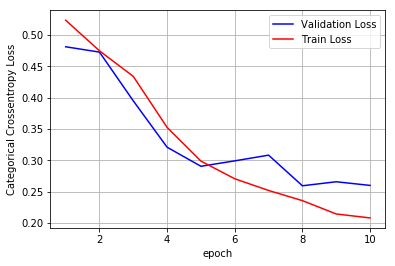

In [39]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [40]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 30000 samples, validate on 16072 samples
Epoch 1/10
30000/30000 [==============================] - 1098s 37ms/step - loss: 0.2980 - acc: 0.8861 - val_loss: 0.2314 - val_acc: 0.9090
Epoch 2/10
30000/30000 [==============================] - 1097s 37ms/step - loss: 0.1853 - acc: 0.9289 - val_loss: 0.2398 - val_acc: 0.8979
Epoch 3/10
30000/30000 [==============================] - 1091s 36ms/step - loss: 0.1587 - acc: 0.9403 - val_loss: 0.2326 - val_acc: 0.9075
Epoch 4/10
30000/30000 [==============================] - 1091s 36ms/step - loss: 0.1409 - acc: 0.9473 - val_loss: 0.2660 - val_acc: 0.9113
Epoch 5/10
30000/30000 [==============================] - 1094s 36ms/step - loss: 0.1134 - acc: 0.9588 - val_loss: 0.2537 - val_acc: 0.8940
Epoch 6/10
30000/30000 [==============================] - 1095s 37ms/step - loss: 0.0952 - acc: 0.9663 - val_loss: 0.2698 - val_acc: 0.9062
Epoch 7/10
30000/30000 [==============================] - 1092s 36ms/step - loss: 0.0803 - acc: 0.9731 - val_l

In [42]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.3979016807080502
Test accuracy: 0.9028123444499752


In [24]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_______________

In [25]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Instructions for updating:
Use tf.cast instead.
Train on 30000 samples, validate on 16072 samples
Epoch 1/10
30000/30000 [==============================] - 1174s 39ms/step - loss: 0.2949 - acc: 0.8849 - val_loss: 0.2576 - val_acc: 0.8911
Epoch 2/10
30000/30000 [==============================] - 1159s 39ms/step - loss: 0.1955 - acc: 0.9247 - val_loss: 0.2368 - val_acc: 0.9080
Epoch 3/10
30000/30000 [==============================] - 1144s 38ms/step - loss: 0.1617 - acc: 0.9393 - val_loss: 0.2293 - val_acc: 0.9099
Epoch 4/10
30000/30000 [==============================] - 1137s 38ms/step - loss: 0.1369 - acc: 0.9506 - val_loss: 0.2402 - val_acc: 0.9092
Epoch 5/10
30000/30000 [==============================] - 1134s 38ms/step - loss: 0.1204 - acc: 0.9580 - val_loss: 0.2630 - val_acc: 0.9056
Epoch 6/10
30000/30000 [==============================] - 1136s 38ms/step - loss: 0.1004 - acc: 0.9654 - val_loss: 0.2702 - val_acc: 0.9018
Epoch 7/10
30000/30000 [==============================] - 1135

In [26]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.33695641563136286
Test accuracy: 0.8967147834743654


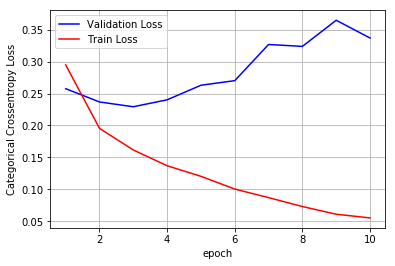

In [29]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [30]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Accuracy"]
x.add_row(["LSTM + DO (0.3)", 0.903])
x.add_row(["LSTM + DO (0.5)", 0.9])
x.add_row(["LSTM + DO (0.3) + MLP + DO (0.3)", 0.81])
x.add_row(["LSTM + DO (0.3) + MLP + DO (0.3)", 0.901])
x.add_row(["LSTM 2-layers + DO (0.3) ", 0.902])
x.add_row(["LSTM 2-layers + DO (0.5) ", 0.89])

print(x)

+----------------------------------+----------+
|              Model               | Accuracy |
+----------------------------------+----------+
|         LSTM + DO (0.3)          |  0.903   |
|         LSTM + DO (0.5)          |   0.9    |
| LSTM + DO (0.3) + MLP + DO (0.3) |   0.81   |
| LSTM + DO (0.3) + MLP + DO (0.3) |  0.901   |
|    LSTM 2-layers + DO (0.3)      |  0.902   |
|    LSTM 2-layers + DO (0.5)      |   0.89   |
+----------------------------------+----------+
